# Medzy
## Overview
This project aims to develop a machine learning model capable of interpreting doctors’ handwriting on prescriptions. By accurately detecting and translating challenging handwriting, the model will empower patients to read their prescriptions independently, making it easier for them to purchase their medications without confusion if they run out of medicine.

This model is using Hugging Face's https://huggingface.co/docs/transformers/en/model_doc/bart for correcting the OCR errors.

## Get PyTorch Device

### DirectML

In [2]:
import torch
import torch_directml

device = torch_directml.device()

ModuleNotFoundError: No module named 'torch_directml'

### CUDA (fallback to CPU if none)

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the data

In [2]:
import json
f = open("output.txt", "r")
texts = json.loads(f.read())

In [3]:
texts

['Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Acatrol',
 'Alatrol',
 'Aletrol',
 'Amodin',
 'Axodin',
 'Axodin',
 'Amodis',
 'Amodis',
 'Amodis',
 'Aodin',
 'Amodis',
 'Amodis',
 'Amodin',
 'Atri',
 'Atri',
 'Atri',
 'Atri',
 'Atri',
 'Atith',
 'Atri',
 'Atri',
 'Atri',
 'Atri',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Azith',
 'Azith',
 'Azith',
 'Azith',
 'Azith',
 'Azith',
 'Azith',
 'Azith',
 'Azithrocin',
 'Azithrocin',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Az',
 'Az',
 'Az',
 'Rico',
 'Az',
 'Az',
 'Az',
 'Az',
 'Az',
 'Az',
 'Baclaid',
 'Baclaid',
 'Bacaidaidzin',
 'Baclaid',
 'Baclaid',
 'Bacaidzin',
 'Baclaid',
 'Bacaidaid',
 'B

In [4]:
# Getting correct labels
import pandas as pd

test_df = pd.read_csv("./Dataset/Testing/testing_labels.csv", delimiter = ",")
valid_labels = test_df["MEDICINE_NAME"].unique() # Get all unique instance of the labels

## Loading the model

In [5]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Load the trained model
model = BartForConditionalGeneration.from_pretrained("./model-output/BART").to(device)
tokenizer = BartTokenizer.from_pretrained("./model-output/BART")

In [6]:
from rapidfuzz import process
import re

def reduce_repetitions(word):
    """Reduces repeated patterns like 'Arolrolrol' to 'Arol'."""
    return re.sub(r'(.{2,})\1+', r'\1', word)

def correct_text(ocr_text):
    """Generate corrected text using the fine-tuned BART model."""
    text = reduce_repetitions(ocr_text)

    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=32).to(device)

        # Generate corrected text
        outputs = model.generate(**inputs, max_length=32, num_return_sequences=1)

    # Decode the corrected text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Find the closest match from the valid labels
    best_match, score, _ = process.extractOne(generated_text, valid_labels)
    # return best_match if score > 80 else generated_text  # Use best match if confidence is high
    
    return best_match # Use best match if confidence is high

In [7]:
corrected_texts = []
for text in texts:
    corrected_text = correct_text(text)
    print(f"OCR Output: {text} -> Corrected: {corrected_text}")
    corrected_texts.append(corrected_text)
    

OCR Output: Aceta -> Corrected: Aceta
OCR Output: Aceta -> Corrected: Aceta
OCR Output: Aceta -> Corrected: Aceta
OCR Output: Aceta -> Corrected: Aceta
OCR Output: Aceta -> Corrected: Aceta
OCR Output: Aceta -> Corrected: Aceta
OCR Output: Aceta -> Corrected: Aceta
OCR Output: Aceta -> Corrected: Aceta
OCR Output: Aceta -> Corrected: Aceta
OCR Output: Aceta -> Corrected: Aceta
OCR Output: Ace -> Corrected: Ace
OCR Output: Ace -> Corrected: Ace
OCR Output: Ace -> Corrected: Ace
OCR Output: Ace -> Corrected: Ace
OCR Output: Ace -> Corrected: Ace
OCR Output: Ace -> Corrected: Ace
OCR Output: Ace -> Corrected: Ace
OCR Output: Ace -> Corrected: Ace
OCR Output: Ace -> Corrected: Ace
OCR Output: Ace -> Corrected: Ace
OCR Output: Alatrol -> Corrected: Alatrol
OCR Output: Alatrol -> Corrected: Alatrol
OCR Output: Alatrol -> Corrected: Alatrol
OCR Output: Alatrol -> Corrected: Alatrol
OCR Output: Alatrol -> Corrected: Alatrol
OCR Output: Alatrol -> Corrected: Alatrol
OCR Output: Alatrol -> Corre

## Calculating Metrics

In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get all unique true labels from the dataset
unique_labels = set(test_df["MEDICINE_NAME"].astype(str))  # Ensure labels are strings

# Add "unknown" to unique labels so sklearn treats it as a valid class
unique_labels.add("unknown")

# Replace unknown predictions with "unknown"
cleaned_predictions = [
    pred if pred in unique_labels else "unknown"
    for pred in corrected_texts
]

# Compute metrics
accuracy = accuracy_score(test_df["MEDICINE_NAME"], cleaned_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_df["MEDICINE_NAME"], cleaned_predictions, labels=list(unique_labels), average="macro", zero_division=0)

# Print results
print(f"Model Performance:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Model Performance:
Accuracy: 91.03%
Precision: 91.21%
Recall: 89.87%
F1-Score: 89.60%


In [9]:
cleaned_predictions

['Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Amodis',
 'Axodin',
 'Axodin',
 'Amodis',
 'Amodis',
 'Amodis',
 'Axodin',
 'Amodis',
 'Amodis',
 'Amodis',
 'Atrizin',
 'Atrizin',
 'Atrizin',
 'Atrizin',
 'Atrizin',
 'Azithrocin',
 'Atrizin',
 'Atrizin',
 'Atrizin',
 'Atrizin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Az',
 'Az',
 'Az',
 'Bicozin',
 'Az',
 'Az',
 'Az',
 'Az',
 'Az',
 'Az',
 'Bacaid',
 'Bacaid',
 'Bacaid',

In [10]:
test_df["MEDICINE_NAME"][41]

'Atrizin'

<AxesSubplot: >

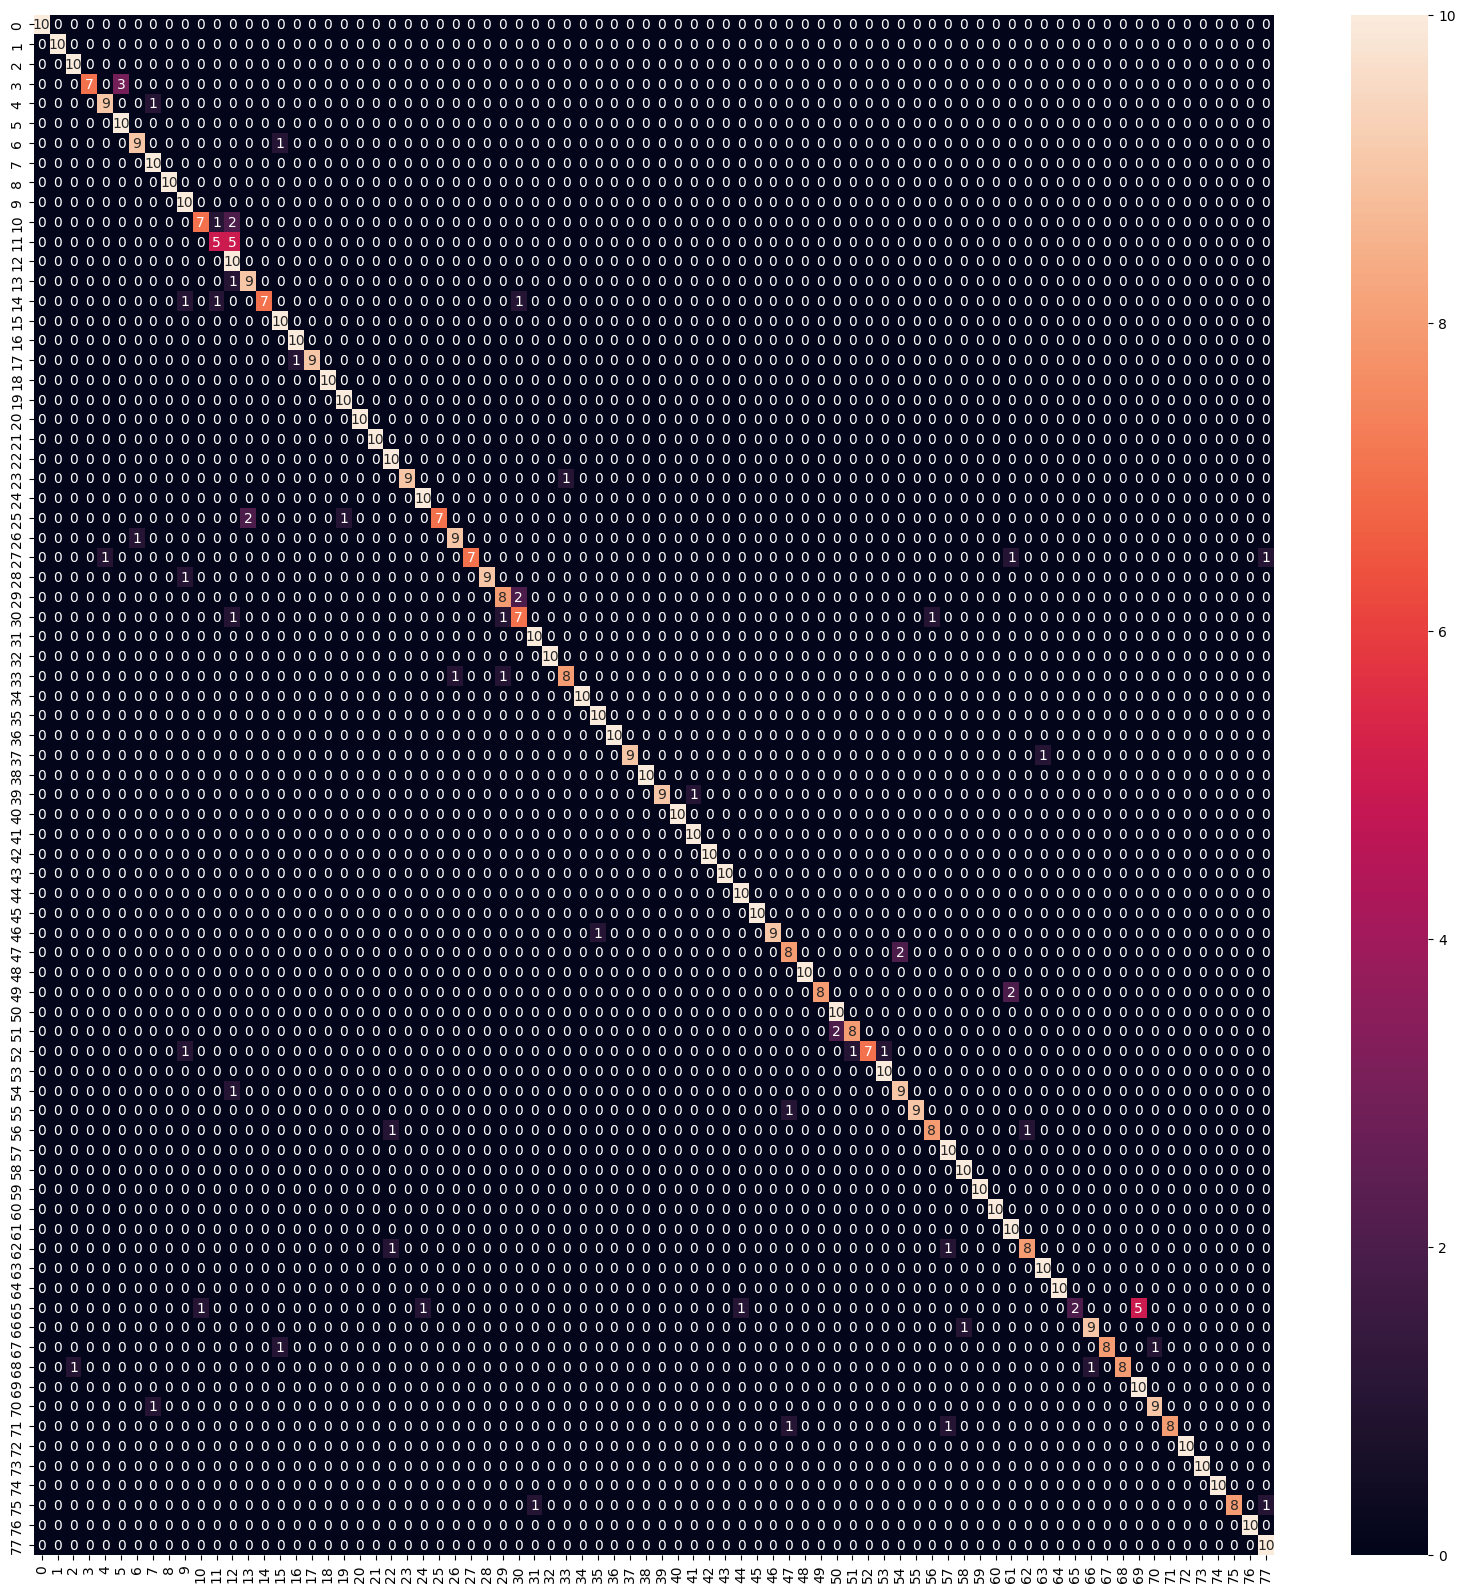

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cf_matrix = confusion_matrix(test_df["MEDICINE_NAME"], cleaned_predictions)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cf_matrix, annot=True)